# ALLERGEN CLASSIFIER

- _Objective_: build a model that identifies protein allergens from amino acid sequences. Purpose is to, through annotated genomes, identify organisms that are likely to contain many allergens so that people (specially the immunocompromised / immunodepressed) can make educated guesses on what to eat.

## Building the allergens and non-allergens sequence datasets

1) Gather allergen amino acid sequences from NCBI's protein database
2) Remove redundant and ambiguous sequences, and outliers by length
3) Calculate min and max allergen length
4) Use min and max allergen length to ather non-allergen amino acid sequences from NCBI's protein database
5) Remove redundant and ambiguous sequences

In [1]:
#Imports

from Bio import Entrez
from Bio import SeqIO
from Bio.SeqUtils import ProtParam
from scipy.stats import ttest_ind, ranksums
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import statistics
import subprocess
from pycaret.classification import *
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier

### Data mining (allergens)

### Scrape NCBI for amino acid sequences of proteins with the terms "allergen" or "allergenic".

In [ ]:
Entrez.email = 'YOUR_EMAIL_ADDRESS'
query = "allergen[All Fileds] OR allergenic[All Fields]"

handle = Entrez.esearch(db="protein", term=query, retmax=500000)
record = Entrez.read(handle)
accession_numbers = record["IdList"]

print(f"{len(accession_numbers)} records found for the query ---{query}---")

with open("allergens.fasta", "w") as f:
    for accession_number in tqdm(accession_numbers):
        handle = Entrez.efetch(db="protein", id=accession_number, rettype="fasta")
        f.write(handle.read())

### Data cleaning (allergens)

Based on their header, filter out proteins that are not explicitly allergens

### Visually examine the sequence headers

In [2]:
subprocess.Popen(['grep', '>', 'allergens.fasta'], 
                 stdout=subprocess.PIPE).stdout.readlines()[:50] #only showing first 50 results

[b'>AAB41117.1 allergen, partial [Ascaris suum]\n',
 b'>AAC34312.1 allergen, partial [Periplaneta americana]\n',
 b'>AAA68279.1 allergen, partial [Dolichovespula maculata]\n',
 b'>ABC73706.1 allergen precursor [Dermatophagoides pteronyssinus]\n',
 b'>ABG35122.1 allergen [Dermatophagoides farinae]\n',
 b'>AAB49396.1 allergen, partial [Blomia tropicalis]\n',
 b'>ADM22286.1 allergen [Salvia miltiorrhiza]\n',
 b'>AAC80579.1 allergen [Blomia tropicalis]\n',
 b'>AAA78904.1 allergen precursor [Blomia tropicalis]\n',
 b'>BAA06172.1 allergen [Cryptomeria japonica]\n',
 b">XP_007296668.1 allergen [Drepanopeziza brunnea f. sp. 'multigermtubi' MB_m1]\n",
 b">XP_007292223.1 allergen [Drepanopeziza brunnea f. sp. 'multigermtubi' MB_m1]\n",
 b">EKD17473.1 allergen [Drepanopeziza brunnea f. sp. 'multigermtubi' MB_m1]\n",
 b">EKD13017.1 allergen [Drepanopeziza brunnea f. sp. 'multigermtubi' MB_m1]\n",
 b'>DAO66287.1 MAG TPA: allergen [Siphoviridae sp.]\n',
 b'>DAK84976.1 MAG TPA: allergen [Myoviridae s

### Keep proteins that contain "allergen" or "allergenic" in their header and remove the ones with the word "precursor" (since they are not actually allergens)

In [3]:
with open("allergens.fasta", "r") as input_handle:
    records = list(SeqIO.parse(input_handle, "fasta"))

filtered_records = []

for record in records:
    if re.search(r"(?i)allergen|allergenic", record.description) and not re.search(r"(?i)precursor", record.description):
        filtered_records.append(record)

with open("allergens_true.fasta", "w") as output_handle:
    SeqIO.write(filtered_records, output_handle, "fasta")

### Remove identical proteins in the dataset with cd-hit 

In [4]:
exe= '/home/mgarciaulloa/cdhit/cd-hit' #write own path to cd-hit executable

cmd = [exe, '-i', "allergens_true.fasta", '-o', "allergens_nr.fasta", '-c', '1', '-T', '0']
cmd[0] = os.path.expanduser(cmd[0])

subprocess.run(cmd)

Program: CD-HIT, V4.8.1 (+OpenMP), Jan 28 2024, 10:28:25
Command: /home/mgarciaulloa/cdhit/cd-hit -i
         allergens_true.fasta -o allergens_nr.fasta -c 1 -T 0

Started: Sun Jan 28 10:32:56 2024
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 16
Actual number of CPUs to be used: 16

total seq: 37592
longest and shortest : 5049 and 11
Total letters: 8865006
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 13M
Buffer          : 16 X 12M = 192M
Table           : 2 X 65M = 131M
Miscellaneous   : 0M
Total           : 338M

Table limit with the given memory limit:
Max number of representatives: 1202309
Max number of word counting entries: 57718230

# comparing sequences from          0  to       2088
..---------- new table with     1560 representatives
# comparing sequences from       2088  to       4060
----------   1659 remaining s

CompletedProcess(args=['/home/mgarciaulloa/cdhit/cd-hit', '-i', 'allergens_true.fasta', '-o', 'allergens_nr.fasta', '-c', '1', '-T', '0'], returncode=0)

### Filter out sequences that contain ambiguities (X, B, Z, J or O) or Selenocysteine (U)

In [5]:
allergens = list(SeqIO.parse('allergens_nr.fasta', "fasta"))

filtered_allergens = [r for r in allergens if not any(c in r.seq for c in "XBZJUO")]

### Remove outliers by length

In [6]:
lengths = [len(r.seq) for r in filtered_allergens]
Q1 = np.quantile(lengths, 0.25)
Q3 = np.quantile(lengths, 0.75)

upper_fence = Q3 + 1.5 * (Q3 - Q1)
lower_fence = Q1 - 1.5 * (Q3 - Q1)

filtered_allergens_nooutliers = [r for r in filtered_allergens if lower_fence <= len(r.seq) <= upper_fence]

SeqIO.write(filtered_allergens_nooutliers, 'filtered_allergens_nooutliers.fasta', "fasta")

19833

In [6]:
#Results (relevant for non-allergen db construction)

In [7]:
lengths = [len(r.seq) for r in filtered_allergens]
lengths_nooutliers = [len(r.seq) for r in filtered_allergens_nooutliers]

mean = sum(lengths) / len(lengths)
mean_nooutliers = sum(lengths_nooutliers) / len(lengths_nooutliers)
std = (sum((x - mean)**2 for x in lengths) / len(lengths))**0.5
std_nooutliers = (sum((x - mean_nooutliers)**2 for x in lengths_nooutliers) / len(lengths_nooutliers))**0.5
min_length = min(lengths_nooutliers)
max_length = max(lengths_nooutliers)

allergens_count = len(allergens)
filtered_allergens_count = len(filtered_allergens)
filtered_allergens_nooutliers_count = len(filtered_allergens_nooutliers)

print(f"Number of unique allergens: {allergens_count}")
print(f"Number of unique unambiguous allergens: {filtered_allergens_count}")
print(f"Number of unique unambiguous allergens without outliers: {filtered_allergens_nooutliers_count}")
print(f"Mean length: {mean_nooutliers:.2f}\nSdev: {std_nooutliers:.2f}")
print(f"Min length: {min_length:.2f}")
print(f"Max length: {max_length:.2f}")

Number of unique allergens: 21307
Number of unique unambiguous allergens: 21050
Number of unique unambiguous allergens without outliers: 19833
Mean length: 205.30
Sdev: 80.00
Min length: 11.00
Max length: 450.00


### Data mining (non-allergens)

### Scrape NCBI for amino acid sequences (lengths 11 to 460, taken from min max in allergens db) of complete proteins from swissprot without "allergen", "allergenic", "partial" or "precursor"

In [ ]:
Entrez.email = 'YOUR_EMAIL_ADDRESS'
query = 'complete[All Fields] NOT allergen[All Fields] NOT allergenic[All Fields] NOT precursor[All Fields] AND (swissprot[filter] AND ("11"[SLEN] : "460"[SLEN]))'

handle = Entrez.esearch(db="protein", term=query, retmax=500000)
record = Entrez.read(handle)
accession_numbers = record["IdList"]

print(f"{len(accession_numbers)} records found for the query ---{query}---")

with open("non-allergens.fasta", "w") as f:
    for accession_number in tqdm(accession_numbers):
        handle = Entrez.efetch(db="protein", id=accession_number, rettype="fasta")
        f.write(handle.read())

### Data cleaning (non-allergens)

In [ ]:
#Remove redundancies in the dataset with cd-hit (sequences that differ >80% in this case)

In [10]:
exe= '/home/mgarciaulloa/cdhit/cd-hit' #write own path to cd-hit executable

cmd = [exe, '-i', "non-allergens.fasta", '-o', "non-allergens_nr.fasta", '-c', '0.7', '-T', '0']
cmd[0] = os.path.expanduser(cmd[0])

subprocess.run(cmd)

Program: CD-HIT, V4.8.1 (+OpenMP), Jan 28 2024, 10:28:25
Command: /home/mgarciaulloa/cdhit/cd-hit -i
         non-allergens.fasta -o non-allergens_nr.fasta -c 0.7
         -T 0

Started: Sun Jan 28 10:33:52 2024
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 16
Actual number of CPUs to be used: 16

total seq: 370762
longest and shortest : 450 and 11
Total letters: 88112660
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 137M
Buffer          : 16 X 15M = 240M
Table           : 2 X 71M = 142M
Miscellaneous   : 4M
Total           : 525M

Table limit with the given memory limit:
Max number of representatives: 683984
Max number of word counting entries: 34323188

# comparing sequences from          0  to       9685
........---------- new table with     4058 representatives
# comparing sequences from       9685  to      29744
........

CompletedProcess(args=['/home/mgarciaulloa/cdhit/cd-hit', '-i', 'non-allergens.fasta', '-o', 'non-allergens_nr.fasta', '-c', '0.7', '-T', '0'], returncode=0)

### Filter out the sequences that contain ambiguities (X, B, Z, J or O) and Selenocysteine (U)

In [11]:
non_allergens = list(SeqIO.parse('non-allergens_nr.fasta', "fasta"))

filtered_non_allergens = [r for r in non_allergens if not any(c in r.seq for c in "XBZJUO")]

SeqIO.write(filtered_non_allergens, 'filtered_non_allergens.fasta', "fasta")

133201

In [12]:
lengths = [len(r.seq) for r in filtered_non_allergens]

mean = sum(lengths) / len(lengths)
std = (sum((x - mean)**2 for x in lengths) / len(lengths))**0.5
min_length = min(lengths)
max_length = max(lengths)

non_allergens_count = len(non_allergens)
filtered_non_allergens_count = len(filtered_non_allergens)

print(f"Number of unique non-allergens: {non_allergens_count}")
print(f"Number of unambiguous non-allergens: {filtered_non_allergens_count}")
print(f"Mean length: {mean:.2f}\nSdev: {std:.2f}")
print(f"Min length: {min_length:.2f}")
print(f"Max length: {max_length:.2f}")

Number of unique non-allergens: 133460
Number of unambiguous non-allergens: 133201
Mean length: 245.60
Sdev: 109.05
Min length: 11.00
Max length: 450.00


### Feature extraction 
- sequence length
- physicochemical properties
- amino acid proportions

In [14]:
features = []
labels = []

# Loop through the fasta records in each file, calculate physicochemical properties of each seq and label as allergen or non-allergen
for file in ['filtered_allergens_nooutliers.fasta', 'filtered_non_allergens.fasta']:
    for record in SeqIO.parse(file, 'fasta'):
        sequence = str(record.seq)

        X = ProtParam.ProteinAnalysis(sequence)
        properties = [len(sequence),
                      X.molecular_weight(),
                      X.charge_at_pH(7),
                      X.aromaticity(),
                      X.instability_index(),
                      statistics.mean(X.flexibility()), #mean calculated from individual amino acids
                      X.gravy(),
                      X.isoelectric_point(),
                      sum(X.secondary_structure_fraction()), #portion of the protein with Helix, Turn, Sheet structures
                      X.molar_extinction_coefficient()[0], # with reduced cysteines
                      X.molar_extinction_coefficient()[1]] # with disulfid bridges

        aa_composition = ProtParam.ProteinAnalysis(sequence).get_amino_acids_percent()
        aa_feat = [aa_composition[aa] for aa in aa_composition.keys()]
        
        combined_features = properties + aa_feat
        
        features.append(combined_features)
        if file == 'filtered_allergens_nooutliers.fasta':
            label = 'allergen'
        else:
            label = 'non-allergen'
        labels.append(label)

In [15]:
features = pd.DataFrame(features)
features.columns=["Seq_length", "Molecular_weight", "Charge_at_pH7", "Aromaticity", "Instability_index", "Mean_flexibility", 
                 "Gravy", "Isoelectric_point", "Secondary_structure_fraction", "Molar_extinction_coeff_reduced",
                 "Molar_extinction_coeff_oxidized", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N",
                 "P", "Q", "R", "S", "T", "V", "W", "Y"]
labels = pd.DataFrame(labels)
labels.columns=["Label"]

print(f"Features = {features.shape}")
print(f"Labels = {labels.shape}")

Features = (153034, 31)
Labels = (153034, 1)


In [16]:
features

,Seq_length,Molecular_weight,Charge_at_pH7,Aromaticity,Instability_index,Mean_flexibility,Gravy,Isoelectric_point,Secondary_structure_fraction,Molar_extinction_coeff_reduced,...,M,N,P,Q,R,S,T,V,W,Y
0,395,45167.6776,1.760100,0.063291,53.801519,1.017519,-0.949620,7.446726,0.962025,30370,...,0.005063,0.007595,0.007595,0.022785,0.045570,0.043038,0.035443,0.040506,0.005063,0.032911
1,228,25791.0516,-19.964660,0.087719,56.324167,0.996491,0.003947,4.438523,1.030702,10430,...,0.013158,0.048246,0.052632,0.039474,0.048246,0.043860,0.030702,0.048246,0.000000,0.030702
2,331,38928.9177,4.067126,0.132931,41.792175,0.999611,-0.554683,8.656573,0.957704,73340,...,0.024169,0.087613,0.048338,0.033233,0.054381,0.048338,0.051360,0.063444,0.027190,0.048338
3,155,16895.9581,-0.955656,0.070968,31.771613,0.995884,-0.225806,6.629268,0.916129,9970,...,0.019355,0.103226,0.025806,0.045161,0.032258,0.038710,0.064516,0.058065,0.006452,0.019355
4,73,8624.8391,0.869692,0.054795,45.735616,1.012504,-0.787671,8.249713,1.000000,1490,...,0.013699,0.041096,0.027397,0.068493,0.082192,0.027397,0.054795,0.013699,0.000000,0.013699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153029,79,8740.1962,-2.484610,0.012658,55.286076,1.009988,-0.191139,5.144406,1.050633,0,...,0.063291,0.050633,0.050633,0.025316,0.037975,0.050633,0.037975,0.063291,0.000000,0.000000
153030,151,17574.8650,5.912713,0.105960,49.456291,1.005345,-0.805298,9.191918,0.874172,14440,...,0.046358,0.039735,0.066225,0.046358,0.072848,0.072848,0.059603,0.033113,0.006623,0.039735
153031,118,13396.1860,1.903427,0.127119,65.300085,0.994375,-0.147458,8.403986,0.966102,16960,...,0.025424,0.033898,0.059322,0.033898,0.042373,0.144068,0.050847,0.016949,0.016949,0.033898
153032,244,26084.3557,0.930736,0.065574,66.029918,1.002080,-0.369672,7.519537,0.942623,57980,...,0.016393,0.016393,0.147541,0.036885,0.049180,0.122951,0.077869,0.032787,0.040984,0.008197


In [17]:
labels

,Label
0,allergen
1,allergen
2,allergen
3,allergen
4,allergen
...,...
153029,non-allergen
153030,non-allergen
153031,non-allergen
153032,non-allergen


In [18]:
##CHECKPOINT: Export features + labels dataframe

In [19]:
out=pd.concat([features,labels], axis=1)

out.to_csv('features_labels.csv')

## Exploratory data analysis

### Where do allergens come from?

In [20]:
headers = subprocess.Popen(['grep', '>', 'filtered_allergens_nooutliers.fasta'], 
                           stdout=subprocess.PIPE).stdout.readlines()

In [21]:
text = ""

for header in headers:
    match = re.search(r"\[(.*?)\]", header.decode())
    if match:
        text += match.group(1) + " "

text = text.replace("'", "")
text = text.replace("sp.", "")
text = text.replace(" sp", "")
text = text.replace("var.", "")
text = text.replace("  ", " ")

text = re.sub(r'\b[a-z]+\b', '', text)

words = text.split()

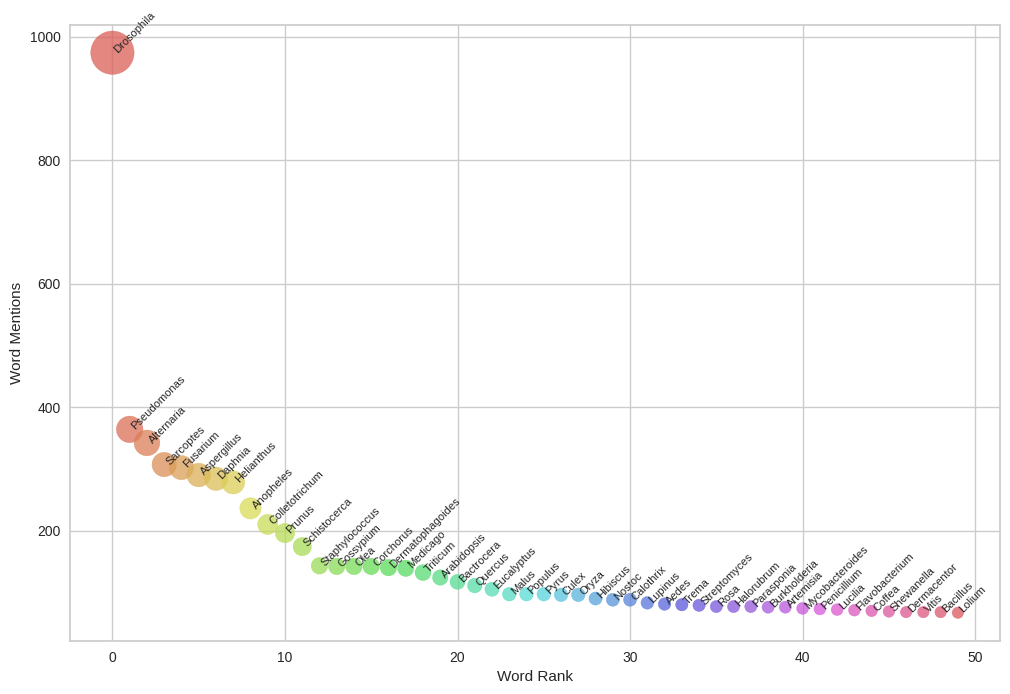

In [22]:
word_counts = {}

for word in words:
    if len(word) < 3 or word == "ATCC" or word == "DSM" or word == "JCM" or word == "CBS" or word == "PCC" or word == "Candidatus":
        continue
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


labels = [word[0] for word in sorted_words[:50]]
sizes = [word[1] for word in sorted_words[:50]]

palette = sns.color_palette("hls", len(labels))

plt.figure(figsize=(12, 8))
plt.scatter(range(len(labels)), sizes, c=palette, alpha=0.75, s=sizes)

for label, x, y in zip(labels, range(len(labels)), sizes):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', rotation=45, fontsize=8)

plt.xlabel('Word Rank')
plt.ylabel('Word Mentions')
plt.savefig("allergens_organisms.png")

https://www.linkedin.com/posts/manuel-garc%C3%ADa-ulloa-gamiz-6607959a_datascience-project-medicine-activity-7024799690294460416-I0Sc?utm_source=share&utm_medium=member_desktop

In [24]:
#RESUME CHECKPOINT

In [25]:
in_df = pd.read_csv('features_labels.csv', sep =',', index_col=0)

In [26]:
labels = in_df.iloc[: , -1:]
features = in_df.iloc[:, 0: 31]

In [27]:
labels.shape, features.shape

((153034, 1), (153034, 31))

### Check occurrences of each category

In [29]:
label_counts = labels['Label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2f}%")

non-allergen: 87.04%
allergen: 12.96%


*NOTE: Data is strongly unbalanced

### Boxplots of sequence lengths (length is an important variable as it determines the amount of information within a sequence!)

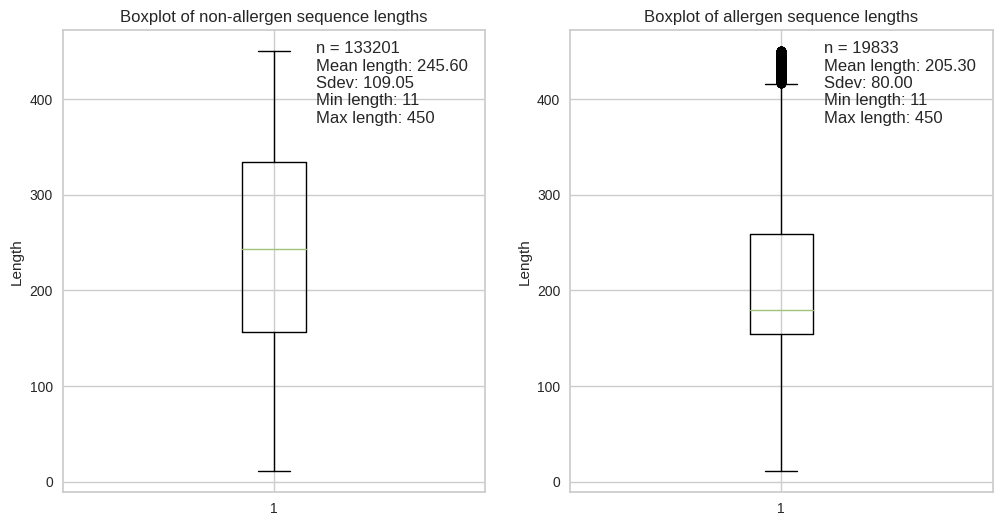

In [31]:
allergen_lengths = features[labels["Label"] == "allergen"]["Seq_length"]
non_allergen_lengths = features[labels["Label"] == "non-allergen"]["Seq_length"]

min_allergen_lengths = min(allergen_lengths)
max_allergen_lengths = max(allergen_lengths)
mean = sum(allergen_lengths) / len(allergen_lengths)
std = (sum((x - mean)**2 for x in allergen_lengths) / len(allergen_lengths))**0.5

min_non_allergen_lengths = min(non_allergen_lengths)
max_non_allergen_lengths = max(non_allergen_lengths)
mean_non = sum(non_allergen_lengths) / len(non_allergen_lengths)
std_non = (sum((x - mean_non)**2 for x in non_allergen_lengths) / len(non_allergen_lengths))**0.5

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.boxplot(non_allergen_lengths)
ax1.set_ylabel('Length')
ax1.set_title('Boxplot of non-allergen sequence lengths')
ymin, ymax = ax1.get_ylim()
ax1.text(1.1, ymax - (ymax - ymin) * 0.2, f"n = {len(non_allergen_lengths)}\nMean length: {mean_non:.2f}\nSdev: {std_non:.2f}\nMin length: {min_non_allergen_lengths}\nMax length: {max_non_allergen_lengths}")

ax2.boxplot(allergen_lengths)
ax2.set_ylabel('Length')
ax2.set_title('Boxplot of allergen sequence lengths')
ymin, ymax = ax2.get_ylim()
ax2.text(1.1, ymax - (ymax - ymin) * 0.2, f"n = {len(allergen_lengths)}\nMean length: {mean:.2f}\nSdev: {std:.2f}\nMin length: {min_allergen_lengths}\nMax length: {max_allergen_lengths}")

plt.savefig("seq_len_boxplots.png")

### Histograms of sequence lengths

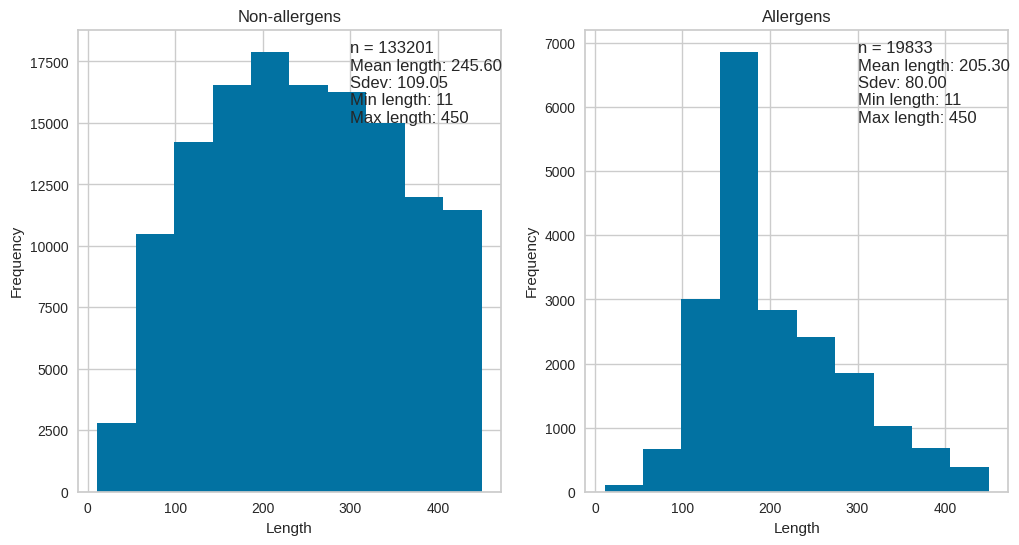

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.hist(non_allergen_lengths)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Length')
ax1.set_title('Non-allergens')
ymin, ymax = ax1.get_ylim()
ax1.text(300, ymax - (ymax - ymin) * 0.2, f"n = {len(non_allergen_lengths)}\nMean length: {mean_non:.2f}\nSdev: {std_non:.2f}\nMin length: {min_non_allergen_lengths}\nMax length: {max_non_allergen_lengths}")

ax2.hist(allergen_lengths)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Length')
ax2.set_title('Allergens')
ymin, ymax = ax2.get_ylim()
ax2.text(300, ymax - (ymax - ymin) * 0.2, f"n = {len(allergen_lengths)}\nMean length: {mean:.2f}\nSdev: {std:.2f}\nMin length: {min_allergen_lengths}\nMax length: {max_allergen_lengths}")

plt.savefig("seq_len_histograms.png")

### Counts of each amino acid on each dataset

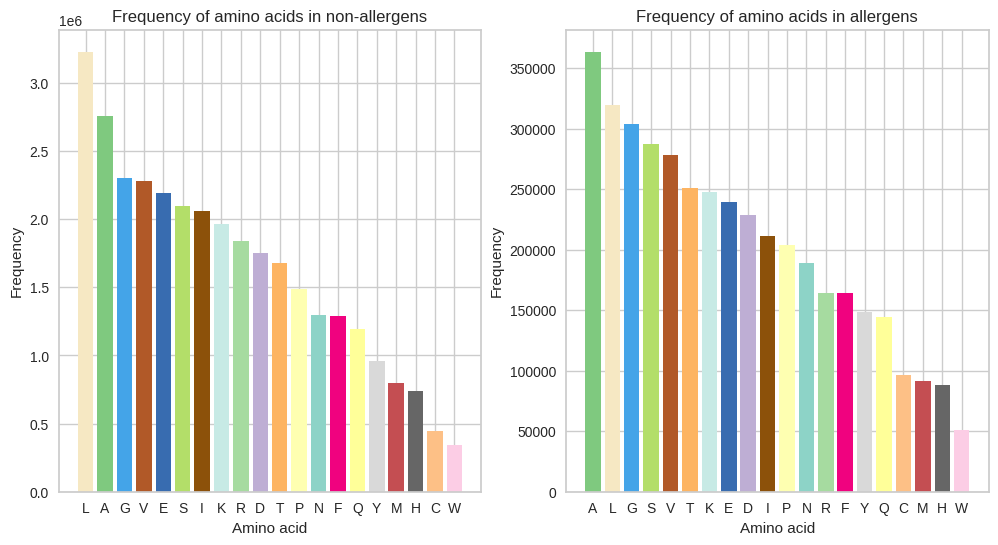

In [33]:
allergen_sequences = [r.seq for r in filtered_allergens_nooutliers]
non_allergen_sequences = [r.seq for r in filtered_non_allergens]

allergen_amino_acids = {}
for seq in allergen_sequences:
    for aa in seq:
        if aa not in allergen_amino_acids:
            allergen_amino_acids[aa] = 0
        allergen_amino_acids[aa] += 1

allergen_aa_counts = [(aa, count) for aa, count in allergen_amino_acids.items()]
allergen_aa_counts.sort(key=lambda x: x[1], reverse=True)
allergen_aa_counts = list(zip(*allergen_aa_counts))

non_allergen_amino_acids = {}
for seq in non_allergen_sequences:
    for aa in seq:
        if aa not in non_allergen_amino_acids:
            non_allergen_amino_acids[aa] = 0
        non_allergen_amino_acids[aa] += 1

non_allergen_aa_counts = [(aa, count) for aa, count in non_allergen_amino_acids.items()]
non_allergen_aa_counts.sort(key=lambda x: x[1], reverse=True)
non_allergen_aa_counts = list(zip(*non_allergen_aa_counts))

colors = {'A': '#7fc97f', 'C': '#fdc086', 'D': '#beaed4', 'E': '#386cb0', 'F': '#f0027f', 'G': '#44a4e8', 'H': '#666666', 'I': '#8c510a', 'K': '#c7eae5', 'L': '#f6e8c3', 'M': '#c44e52', 'N': '#8dd3c7', 'P': '#feffb1', 'Q': '#ffff99', 'R': '#a6dba0', 'S': '#b3de69', 'T': '#fdb462', 'V': '#b15928', 'W': '#fccde5', 'Y': '#d9d9d9'}

allergen_colors_list = [colors[aa] for aa in allergen_aa_counts[0]]
non_allergen_colors_list = [colors[aa] for aa in non_allergen_aa_counts[0]]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.bar(non_allergen_aa_counts[0], non_allergen_aa_counts[1], color=non_allergen_colors_list)
ax1.set_xlabel('Amino acid')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency of amino acids in non-allergens')

ax2.bar(allergen_aa_counts[0], allergen_aa_counts[1], color=allergen_colors_list)
ax2.set_xlabel('Amino acid')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency of amino acids in allergens')

plt.savefig('seq_composition.png')

### Boxplots of abundance of each amino acid

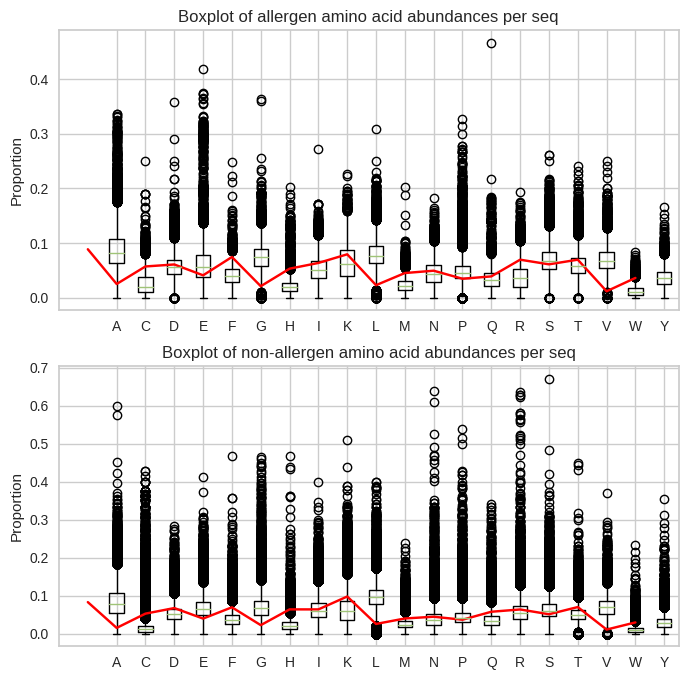

In [34]:
aa_proportions = features.iloc[:, 11:31]

allergen_aa_proportions = aa_proportions[labels["Label"] == "allergen"]
non_allergen_aa_proportions = aa_proportions[labels["Label"] == "non-allergen"]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

allergen_means = allergen_aa_proportions.mean()
non_allergen_means = non_allergen_aa_proportions.mean()

ax1.boxplot(allergen_aa_proportions)
ax1.set_ylabel('Proportion')
ax1.set_title('Boxplot of allergen amino acid abundances per seq')
ax1.set_xticklabels(allergen_aa_proportions.columns)
ax1.plot(allergen_means, color='red', linestyle='-')

ax2.boxplot(non_allergen_aa_proportions)
ax2.set_ylabel('Proportion')
ax2.set_title('Boxplot of non-allergen amino acid abundances per seq')
ax2.set_xticklabels(allergen_aa_proportions.columns)
ax2.plot(non_allergen_means, color='red', linestyle='-')

plt.savefig('aminoacid_abundances.png')

## Feature engineering

### importance of features: p<0.05 = significantly different between categories, thus, probably relevant

In [35]:
results = {}

for column in features.columns:
    allergen = features[labels["Label"] == "allergen"][column]
    non_allergen = features[labels["Label"] == "non-allergen"][column]

    t_stat, t_pvalue = ttest_ind(allergen, non_allergen)
    r_stat, r_pvalue = ranksums(allergen, non_allergen)

    results[column] = {'t-test (stat, p-val)': (np.round(t_stat, 5), np.round(t_pvalue, 5)), 
                       'Wilcoxon rank-sum test (stat, p-val)': (np.round(r_stat, 5), np.round(r_pvalue, 5))}

mean_comparison_results_df = pd.DataFrame(results).T

In [36]:
mean_comparison_results_df

,"t-test (stat, p-val)","Wilcoxon rank-sum test (stat, p-val)"
Seq_length,"(-50.0706, 0.0)","(-50.90175, 0.0)"
Molecular_weight,"(-53.14015, 0.0)","(-54.12531, 0.0)"
Charge_at_pH7,"(-24.5698, 0.0)","(-23.67875, 0.0)"
Aromaticity,"(36.17911, 0.0)","(53.08135, 0.0)"
Instability_index,"(-31.77222, 0.0)","(-34.85859, 0.0)"
Mean_flexibility,"(17.77889, 0.0)","(10.19118, 0.0)"
Gravy,"(-9.89178, 0.0)","(-5.7988, 0.0)"
Isoelectric_point,"(-43.37367, 0.0)","(-45.57963, 0.0)"
Secondary_structure_fraction,"(-14.32476, 0.0)","(-16.66789, 0.0)"
Molar_extinction_coeff_reduced,"(1.9613, 0.04985)","(3.93379, 8e-05)"


All features are important

### Draw a correlation plot

<AxesSubplot: >

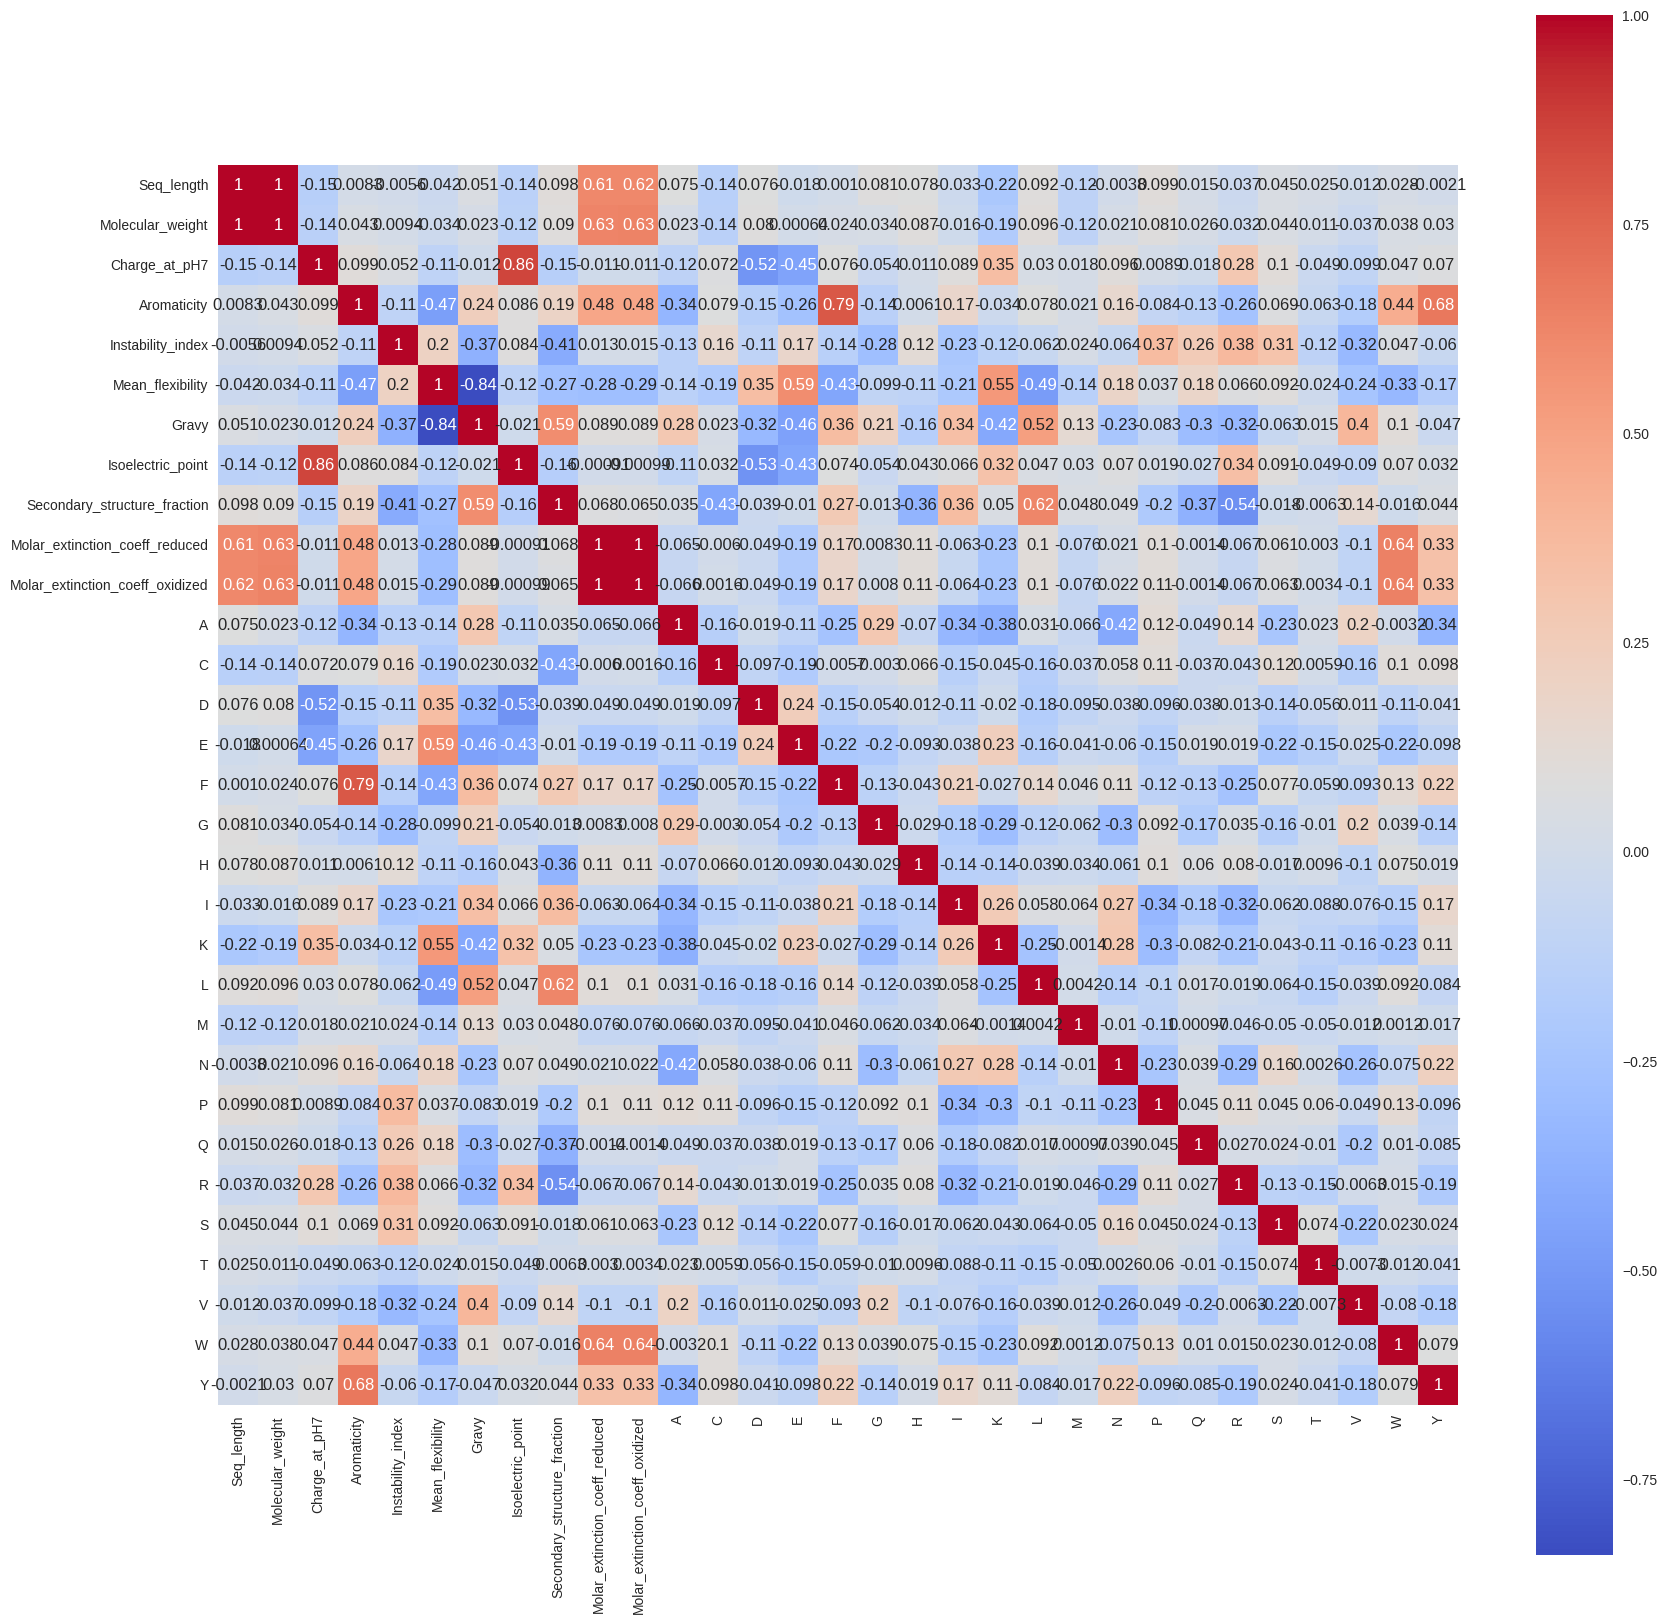

In [38]:
features_corr_matrix = features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(features_corr_matrix, annot=True, cmap='coolwarm', square=True)

Amino acids alone are not strongly correlated between each other. That's good! All of them will be kept.

However, because physicochemical properties are calculated from amino acids, it is expected that some of them are correlated to amino acids. Moreover, a couple of them are 100% correlated.

In [39]:
#Drop Molecular_weight and Molar_extinction_coeff_reduced for having R2=1

In [40]:
features = features.drop(["Molecular_weight", "Molar_extinction_coeff_reduced", "Molar_extinction_coeff_oxidized"], axis=1)
features.shape

(153034, 28)

In [41]:
#Drop everything with R > 0.6

In [42]:
features = features.drop(["Aromaticity", "Mean_flexibility", "Charge_at_pH7", "Secondary_structure_fraction"], axis=1)
features.shape

(153034, 24)

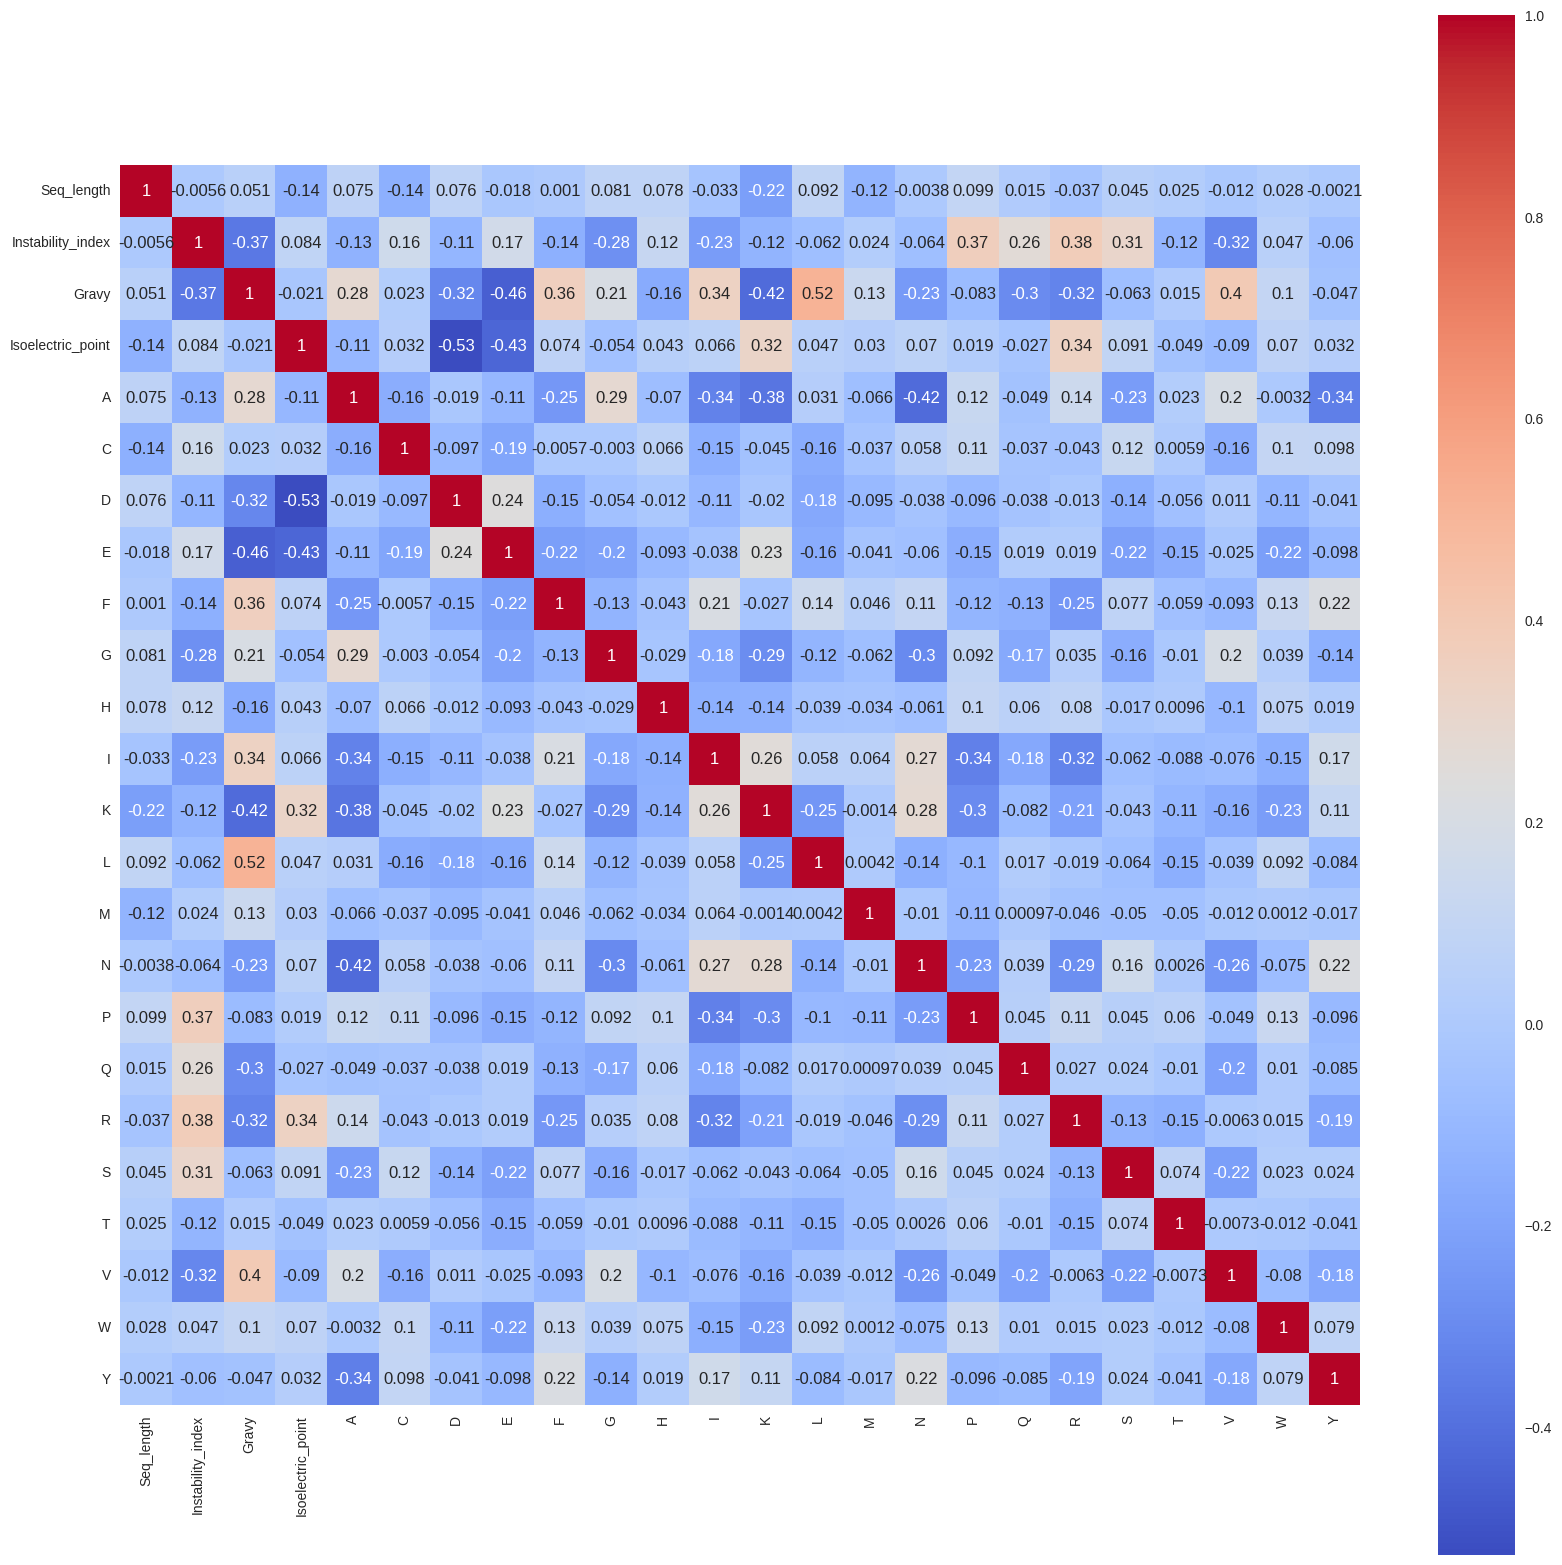

In [43]:
features_corr_matrix = features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(features_corr_matrix, annot=True, cmap='coolwarm', square=True)

plt.savefig('corrplot_filtered.png')

### Plot PCA of the final variables

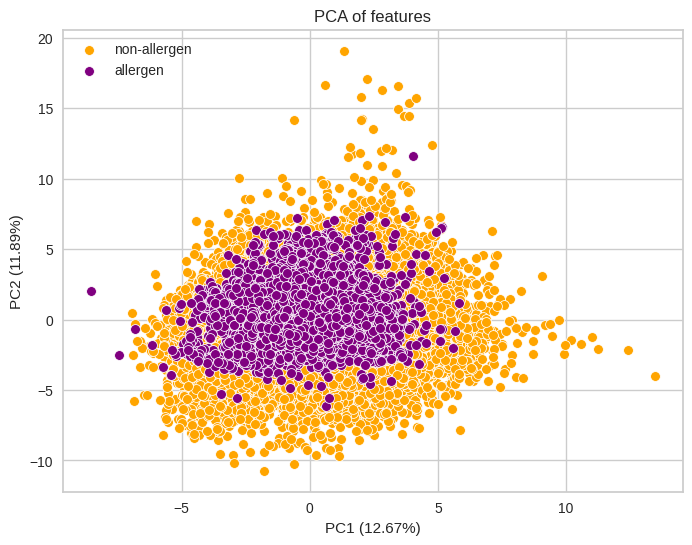

In [48]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Label'] = labels['Label']

# Plot the scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Label'] == 'non-allergen'], color='orange', s=50, label='non-allergen')
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Label'] == 'allergen'], color='purple', s=50, label='allergen')
plt.title('PCA of features')
plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
plt.legend(loc='upper left')

plt.savefig("pca_features.png")
plt.show()


## Model building

### Preprocessing

In [10]:
#Split data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

In [61]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (137730, 24)
X_test: (15304, 24)
y_train: (137730, 1)
y_test: (15304, 1)


In [62]:
#Standarize the data

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
X_train.shape, X_test.shape

((137730, 24), (15304, 24))

### Model training

In [78]:
data=pd.concat([features,labels], axis=1)

In [79]:
#label encoding

data['Label'] = data['Label'].map({'non-allergen': 0, 'allergen': 1})

In [86]:
s = setup(data=data, train_size=0.7, target='Label', normalize=True, normalize_method='zscore', 
          data_split_shuffle=True, session_id=42)

,Description,Value
0,Session id,42
1,Target,Label
2,Target type,Binary
3,Original data shape,"(153034, 25)"
4,Transformed data shape,"(153034, 25)"
5,Transformed train set shape,"(107123, 25)"
6,Transformed test set shape,"(45911, 25)"
7,Numeric features,24
8,Preprocess,True
9,Imputation type,simple


In [87]:
compare_models(exclude = ['lightgbm', 'catboost']) #exclude models that crash my laptop

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9507,0.9479,0.7858,0.8254,0.8051,0.7769,0.7772,1.4330
xgboost,Extreme Gradient Boosting,0.9500,0.9618,0.7240,0.8685,0.7896,0.7615,0.7656,0.7110
rf,Random Forest Classifier,0.9481,0.9622,0.6264,0.9593,0.7579,0.7303,0.7511,4.0620
et,Extra Trees Classifier,0.9469,0.9672,0.6021,0.9804,0.7460,0.7182,0.7449,2.5240
gbc,Gradient Boosting Classifier,0.9239,0.9264,0.5084,0.8418,0.6338,0.5943,0.6179,7.7700
ada,Ada Boost Classifier,0.9073,0.8949,0.4586,0.7252,0.5618,0.5129,0.5298,1.7530
qda,Quadratic Discriminant Analysis,0.9067,0.8927,0.5744,0.6615,0.6148,0.5621,0.5639,0.2220
dt,Decision Tree Classifier,0.9046,0.8038,0.6674,0.6235,0.6446,0.5896,0.5901,0.5590
nb,Naive Bayes,0.8889,0.8538,0.4755,0.5885,0.5259,0.4638,0.4672,0.1370
lr,Logistic Regression,0.8770,0.8475,0.2082,0.5699,0.3049,0.2531,0.2921,0.4780


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [88]:
# create best models

model_knn = create_model('knn') 
model_xgboost = create_model('xgboost') 
model_rf = create_model('rf') 
model_et = create_model('et') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9529,0.9475,0.7941,0.8343,0.8137,0.7868,0.7871
1,0.9524,0.9486,0.7855,0.8373,0.8105,0.7834,0.7839
2,0.9491,0.9502,0.7912,0.8117,0.8013,0.7721,0.7722
3,0.9499,0.9447,0.7810,0.8231,0.8015,0.7728,0.7732
4,0.9476,0.9417,0.7651,0.8188,0.7911,0.7612,0.7617
5,0.9513,0.9499,0.7903,0.8261,0.8078,0.7799,0.7802
6,0.9540,0.9538,0.8033,0.8352,0.8189,0.7926,0.7928
7,0.9493,0.9476,0.7839,0.8174,0.8003,0.7713,0.7715
8,0.9521,0.9512,0.7925,0.8302,0.8109,0.7835,0.7838


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9504,0.9611,0.7135,0.8817,0.7887,0.7610,0.7664
1,0.9513,0.9649,0.7379,0.8664,0.7970,0.7696,0.7728
2,0.9495,0.9659,0.7307,0.8587,0.7896,0.7611,0.7643
3,0.9467,0.9598,0.6996,0.8631,0.7728,0.7430,0.7482
4,0.9499,0.9611,0.7176,0.8729,0.7877,0.7595,0.7642
5,0.9528,0.9634,0.7356,0.8802,0.8014,0.7748,0.7789
6,0.9486,0.9632,0.7241,0.8568,0.7848,0.7559,0.7593
7,0.9496,0.9605,0.7154,0.8726,0.7862,0.7580,0.7628
8,0.9515,0.9604,0.7370,0.8692,0.7977,0.7704,0.7737


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9476,0.9614,0.6213,0.9610,0.7547,0.7269,0.7486
1,0.9486,0.9659,0.6256,0.9656,0.7593,0.7320,0.7536
2,0.9493,0.9628,0.6407,0.9529,0.7663,0.7390,0.7574
3,0.9442,0.9584,0.5987,0.9530,0.7354,0.7060,0.7299
4,0.9488,0.9588,0.6275,0.9656,0.7607,0.7335,0.7549
5,0.9490,0.9643,0.6326,0.9606,0.7628,0.7356,0.7558
6,0.9483,0.9685,0.6311,0.9542,0.7598,0.7321,0.7518
7,0.9487,0.9625,0.6311,0.9584,0.7611,0.7337,0.7538
8,0.9481,0.9625,0.6290,0.9551,0.7585,0.7308,0.7508


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9651,0.6040,0.9847,0.7488,0.7213,0.7482
1,0.9476,0.9718,0.6127,0.9737,0.7521,0.7245,0.7489
2,0.9497,0.9673,0.6242,0.9808,0.7629,0.7363,0.7598
3,0.9440,0.9630,0.5778,0.9828,0.7278,0.6989,0.7296
4,0.9474,0.9644,0.6016,0.9882,0.7479,0.7205,0.7482
5,0.9473,0.9707,0.6037,0.9824,0.7479,0.7203,0.7470
6,0.9459,0.9718,0.5987,0.9742,0.7416,0.7134,0.7398
7,0.9467,0.9675,0.6001,0.9812,0.7447,0.7169,0.7440
8,0.9461,0.9664,0.5980,0.9776,0.7421,0.7139,0.7409


model variance is low across the board. good!

### optimizing for auc, f1 (because unbalanced data) and recall (because there's a clear drop with model performance and also unbalanced data)

In [90]:
tuned_AUC_model_knn = tune_model(model_knn, n_iter = 5, optimize = 'AUC', verbose = False)
tuned_f1_model_knn = tune_model(model_knn, n_iter = 5, optimize = 'f1', verbose = False)
tuned_recall_model_knn = tune_model(model_knn, n_iter = 5, optimize = 'recall', verbose = False)

In [91]:
tuned_AUC_model_xgboost = tune_model(model_xgboost, n_iter = 5, optimize = 'AUC', verbose = False)
tuned_f1_model_xgboost = tune_model(model_xgboost, n_iter = 5, optimize = 'f1', verbose = False)
tuned_recall_model_xgboost = tune_model(model_xgboost, n_iter = 5, optimize = 'recall', verbose = False)

In [92]:
tuned_AUC_model_rf = tune_model(model_rf, n_iter = 5, optimize = 'AUC', verbose = False)
tuned_f1_model_rf = tune_model(model_rf, n_iter = 5, optimize = 'f1', verbose = False)
tuned_recall_model_rf = tune_model(model_rf, n_iter = 5, optimize = 'recall', verbose = False)

In [93]:
tuned_AUC_model_et = tune_model(model_et, n_iter = 5, optimize = 'AUC', verbose = False)
tuned_f1_model_et = tune_model(model_et, n_iter = 5, optimize = 'f1', verbose = False)
tuned_recall_model_et = tune_model(model_et, n_iter = 5, optimize = 'recall', verbose = False)

In [186]:
# extract and concat final results from models

predict_model(model_knn, verbose = False)
model_knn_results = pull()
model_knn_results["Model"] = "model_knn_results"
predict_model(tuned_AUC_model_knn, verbose = False)
tuned_AUC_model_knn_results = pull()
tuned_AUC_model_knn_results["Model"] = "tuned_AUC_model_knn_results"
predict_model(tuned_f1_model_knn, verbose = False)
tuned_f1_model_knn_results = pull()
tuned_f1_model_knn_results["Model"] = "tuned_f1_model_knn_results"
predict_model(tuned_recall_model_knn, verbose = False)
tuned_recall_model_knn_results = pull()
tuned_recall_model_knn_results["Model"] = "tuned_recall_model_knn_results"

predict_model(model_xgboost, verbose = False)
model_xgboost_results = pull()
model_xgboost_results["Model"] = "model_xgboost_results"
predict_model(tuned_AUC_model_xgboost, verbose = False)
tuned_AUC_model_xgboost_results = pull()
tuned_AUC_model_xgboost_results["Model"] = "tuned_AUC_model_xgboost_results"
predict_model(tuned_f1_model_xgboost, verbose = False)
tuned_f1_model_xgboost_results = pull()
tuned_f1_model_xgboost_results["Model"] = "tuned_f1_model_xgboost_results"
predict_model(tuned_recall_model_xgboost, verbose = False)
tuned_recall_model_xgboost_results = pull()
tuned_recall_model_xgboost_results["Model"] = "tuned_recall_model_xgboost_results"

predict_model(model_rf, verbose = False)
model_rf_results = pull()
model_rf_results["Model"] = "model_rf_results"
predict_model(tuned_AUC_model_rf, verbose = False)
tuned_AUC_model_rf_results = pull()
tuned_AUC_model_rf_results["Model"] = "tuned_AUC_model_rf_results"
predict_model(tuned_f1_model_rf, verbose = False)
tuned_f1_model_rf_results = pull()
tuned_f1_model_rf_results["Model"] = "tuned_f1_model_rf_results"
predict_model(tuned_recall_model_rf, verbose = False)
tuned_recall_model_rf_results = pull()
tuned_recall_model_rf_results["Model"] = "tuned_recall_model_rf_results"

predict_model(model_et, verbose = False)
model_et_results = pull()
model_et_results["Model"] = "model_et_results"
predict_model(tuned_AUC_model_et, verbose = False)
tuned_AUC_model_et_results = pull()
tuned_AUC_model_et_results["Model"] = "tuned_AUC_model_et_results"
predict_model(tuned_f1_model_et, verbose = False)
tuned_f1_model_et_results = pull()
tuned_f1_model_et_results["Model"] = "tuned_f1_model_et_results"
predict_model(tuned_recall_model_et, verbose = False)
tuned_recall_model_et_results = pull()
tuned_recall_model_et_results["Model"] = "tuned_recall_model_et_results"


In [193]:
models_results_final = pd.concat([model_knn_results, tuned_AUC_model_knn_results, tuned_f1_model_knn_results, tuned_recall_model_knn_results,
                                 model_xgboost_results, tuned_AUC_model_xgboost_results, tuned_f1_model_xgboost_results, tuned_recall_model_xgboost_results,
                                 model_rf_results, tuned_AUC_model_rf_results, tuned_f1_model_rf_results, tuned_recall_model_rf_results,
                                 model_et_results, tuned_AUC_model_et_results, tuned_f1_model_et_results, tuned_recall_model_et_results,], ignore_index=True)

In [194]:
models_results_final = models_results_final[(models_results_final.iloc[:, 1:] >= 0.5).all(axis=1)]
models_results_final

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,model_knn_results,0.9507,0.9465,0.7886,0.8236,0.8057,0.7775,0.7777
1,tuned_AUC_model_knn_results,0.9478,0.9617,0.7096,0.8630,0.7788,0.7495,0.7541
2,tuned_f1_model_knn_results,0.9537,0.9244,0.7387,0.8850,0.8052,0.7792,0.7833
3,tuned_recall_model_knn_results,0.9507,0.9465,0.7886,0.8236,0.8057,0.7775,0.7777
4,model_xgboost_results,0.9505,0.9599,0.7261,0.8704,0.7917,0.7639,0.7679
5,tuned_AUC_model_xgboost_results,0.9405,0.9673,0.8635,0.7278,0.7899,0.7555,0.7592
6,tuned_f1_model_xgboost_results,0.9405,0.9673,0.8635,0.7278,0.7899,0.7555,0.7592
8,model_rf_results,0.9492,0.9621,0.6333,0.9612,0.7635,0.7364,0.7565
9,tuned_AUC_model_rf_results,0.9492,0.9621,0.6333,0.9612,0.7635,0.7364,0.7565
10,tuned_f1_model_rf_results,0.9492,0.9621,0.6333,0.9612,0.7635,0.7364,0.7565


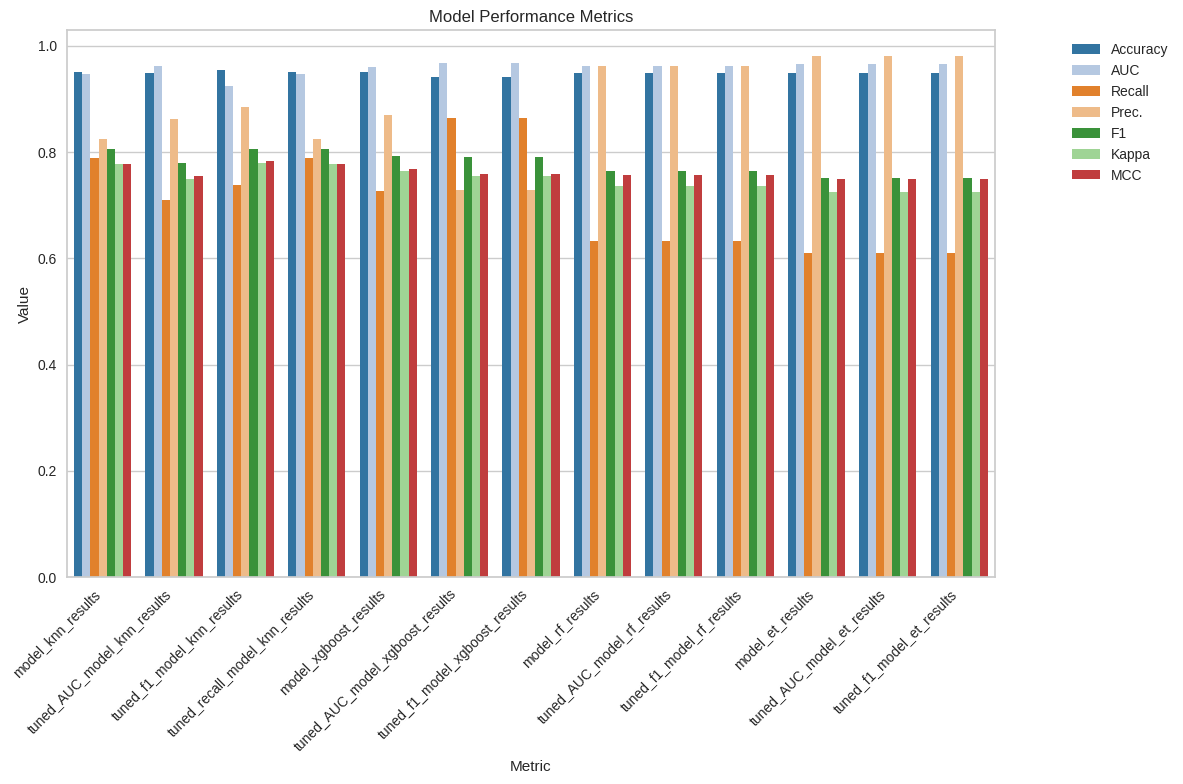

In [199]:
# Melt the DataFrame for better visualization
models_results_melted = pd.melt(models_results_final, id_vars=['Model'], var_name='Metric', value_name='Value')

# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=models_results_melted, palette='tab20')
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()

# Conclusion

- _model_knn_ & _tuned_AUC_model_xgboost_ perform the best

- Since the objective is to identify allergens in genomes to make decisions on what not to eat, higher recall (_tuned_AUC_model_xgboost_) may be preferred over higher precision (_model_knn_). Also, _tuned_AUC_model_xgboost_ has slightly higher AUC, which is to take into account in unbaalnced data

# TO DO

1.- Test best models in out of sample sequences

2.- Collect genomes from foods and use the models on them

3.- Come up with an "allergen index" for each genome